# Prediction of schizophrenia in subject through analysis of brain EEG signals

## Importing the required libraries

In [26]:
import glob
import numpy as np
import pandas
import matplotlib.pyplot as plt
import json
import mne
import os
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv1D, BatchNormalization, LeakyReLU, MaxPool1D, GlobalAveragePooling1D, Dense, Dropout, AveragePooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.backend import clear_session
from sklearn.model_selection import GroupKFold, LeaveOneGroupOut
from sklearn.preprocessing import StandardScaler

## Reading and preparing data for classification - Sayanteka Saha - 21051681

Reading of all files from the dataset. Files are in the format _XX.edf where _ represents h or s - h for healthy subject and s for schizophrenic subject and XX represents the subject number from 01 to 14, for both healthy and schizophrenic subjects

In [3]:
all_file_path=glob.glob("dataverse_files/*.edf")
print(len(all_file_path))

28


Segregating the healthy and the schizophrenic subjects in two different arrays for better understanding

In [4]:
healthy_file_path = [i for i in all_file_path if 'h' in i.split('\\')[1]]
patient_file_path = [i for i in all_file_path if 's' in i.split('\\')[1]]
print(len(healthy_file_path),len(patient_file_path))

14 14


Creating a function to read the data along with setting the EEG reference (standard 10-20 EEG montage), passing the data through a band pass filter and creating overlapping epochs of 5 seconds duration each

In [5]:
def read_data(file_path):
    data=mne.io.read_raw_edf(file_path,preload=True)
    data.set_eeg_reference()
    data.filter(l_freq=0.5, h_freq=45)
    epochs=mne.make_fixed_length_epochs(data,duration=5,overlap=1)
    array=epochs.get_data()
    return array

Reading a sample data to test the function

In [6]:
sample_data=read_data(healthy_file_path[0])

Extracting EDF parameters from d:\KIIT\6th semester\Minor Project\Schizophrenia\dataverse_files\h01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 231249  =      0.000 ...   924.996 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1651 samples (6.604 s)

Not setting metadata
231 matching events found
No baseline correction applied


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.0s finished


In [7]:
sample_data.shape #no of epochs , channels, length of signal

(231, 19, 1250)

Calling the function on all the healthy and the schizophrenic subjects and saving the epochs into two different arrays - control for healthy subjects and patients for schizophrenic subjects

In [8]:
%%capture
control_epochs_array=[read_data(i) for i in healthy_file_path] # [(231, 19, 1250), (), ..., 14]
patients_epochs_array=[read_data(i) for i in patient_file_path]

In [9]:
control_epochs_array[0].shape

(231, 19, 1250)

Labelling healthy subjects as 0 and schizophrenic subjects as 1 and storing the labels corresponding to their respective epoch arrays into two different label arrays for healthy and schizophrenic subjects

In [10]:
control_epoch_label= [len(i) * [0] for i in control_epochs_array] # [[0, 0, ..., 231 times], [0, 0, ..., x times], ... 14 elements]
patient_epoch_label= [len(i) * [1] for i in patients_epochs_array] # [[1, 1, ..., x times], [1, 1, ..., y times], ... 14 elements]
len(control_epoch_label), len(patient_epoch_label)

(14, 14)

Concatenating all the epoch data and labels (healthy and schizophrenic) into one single `data_list` and `label_list` respectively

In [11]:
data_list=control_epochs_array+patients_epochs_array # 28 elements
label_list=control_epoch_label+patient_epoch_label # 28 elements

Assigning groups to the data subject wise and not channel wise to facilitate classification process

In [12]:
group_list=[[i]*len(j) for i,j in enumerate(data_list)]
len(group_list)

28

Finally creating the required arrays by using `numpy` stacks to be able to use them for classification

In [13]:
data_array=np.vstack(data_list)
label_array=np.hstack(label_list)
group_array=np.hstack(group_list)
print(data_array.shape, label_array.shape,group_array.shape)

(7201, 19, 1250) (7201,) (7201,)


## Training and testing the Logistic Regression model for classification - Dipanwita Ghosh - 2105193

### Feature extraction

Features extracted from EEG data - mean, standard deviation, peak to peak value, variance, minimum value, maximum value, root mean square, sum of absolute difference between two signals, skewness and kurtosis

In [18]:
from scipy import stats
def mean(x):
    return np.mean(x, axis=-1)
def std(x):
    return np.std(x,axis=-1)
def ptp(x):
    return np.ptp(x,axis=-1)
def var(x):
    return np.var(x,axis=-1)
def minim(x):
    return np.min(x,axis=-1)
def maxim(x):
    return np.max(x,axis=-1)
def argminim(x):
    return np.argmin(x,axis=-1)
def argmaxim(x):
    return np.argmax(x,axis=-1)
def rms(x):
    return np.sqrt(np.mean(x**2,axis=-1))
def abs_diff_signal(x):
    return np.sum(np.abs(np.diff(x,axis=-1)), axis=-1)

def skewness(x):
    return stats.skew(x,axis=-1)
def kurtosis(x):
    return stats.kurtosis(x,axis=-1)

def concatenate_features(x):
    return np.concatenate((mean(x), std(x), ptp(x), var(x), minim(x), maxim(x),argminim(x), argmaxim(x),rms(x), abs_diff_signal(x), skewness(x),kurtosis(x)), axis=-1)



In [19]:
features=[]
for d in data_array:
    features.append(concatenate_features(d))

In [20]:
features_array = np.array(features)
features_array.shape

(7201, 228)

### Model training

Using the `LogisticRegression` and `StandardScaler` models from the `scikit-learn` library by creating a pipeline that scales the data and then sends it for classification by the LR model. The arguments used for the classifier are `[0.1, 0.5, 0.7, 1, 3, 5, 7]`.<br>

`Grid Search` has been used to extract the best features from the list by trial and error process. Different values for the `param_grid` might result in variable accuracy of the model.

`k-fold Cross Validation` has been used to significantly increase the accuracy and efficiency of the model.

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold, GridSearchCV


In [89]:
clf = LogisticRegression()
gkf = GroupKFold(5)
pipe = Pipeline([('scalar', StandardScaler()),('clf',clf)])
param_grid ={'clf__C':[0.1,0.5,0.7,1,3,5,7]}
gscv = GridSearchCV(pipe, param_grid, cv=gkf, n_jobs=12)
gscv.fit(features_array, label_array, groups=group_array)

C:\Users\KIIT\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


GridSearchCV(cv=GroupKFold(n_splits=5),
             estimator=Pipeline(steps=[('scalar', StandardScaler()),
                                       ('clf', LogisticRegression())]),
             n_jobs=12, param_grid={'clf__C': [0.1, 0.5, 0.7, 1, 3, 5, 7]})

Best accuracy score that has been obtained with the given parameters is `66.03%`

In [90]:
gscv.best_score_

0.663034159305596

## Deep 1D Convolutional Neural Network for classification - Soham Chatterjee - 2105164

In [14]:
data_list = np.vstack(data_list)
label_list = np.hstack(label_list)
groups_array = np.hstack(group_list)

In [15]:
data_list.shape, label_list.shape, groups_array.shape

((7201, 19, 1250), (7201,), (7201,))

In [16]:
data_list = np.moveaxis(data_list, 1, 2)
data_list.shape

(7201, 1250, 19)

### Model Training

CNN model architecture contains a total of 13 layers with 11 hidden layers, 1 input layer and 1 output layer (the output layer uses `sigmoid` activation).

`Batch Normalization` has been done on the input layer to normalize the data being fed to the neural network

The layers of the model in their respective order are:

`Conv1D + Batch Normalization + ReLU` -> `MaxPool1D `-> `Conv1D + ReLU` -> `MaxPool1D + Dropout` -> `Conv1D + ReLU` -> `MaxPool1D + Dropout` -> `Conv1D + ReLU `-> `AveragePooling1D + Dropout` -> `Conv1D + ReLU` -> `AveragePooling1D` -> `Conv1D + ReLU` -> `AveragePooling1D (Global)` -> `Dense (sigmoid activation)`

In [17]:
def cnnModel():
    clear_session()
    model = Sequential()

    model.add(Conv1D(filters=5, kernel_size = 3, strides = 1, input_shape = (1250, 19)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(MaxPool1D(pool_size=2, strides=2))

    model.add(Conv1D(filters=5, kernel_size = 3, strides = 1))
    model.add(LeakyReLU())

    model.add(MaxPool1D(pool_size=2, strides=2))
    model.add(Dropout(0.5))

    model.add(Conv1D(filters=5, kernel_size=3, strides=1))
    model.add(LeakyReLU())

    model.add(MaxPool1D(pool_size=2, strides=2))
    model.add(Dropout(0.5))

    model.add(Conv1D(filters=5, kernel_size=3, strides=1))
    model.add(LeakyReLU())

    model.add(AveragePooling1D(pool_size=2, strides=2))
    model.add(Dropout(0.5))

    model.add(Conv1D(filters=5, kernel_size=3, strides=1))
    model.add(LeakyReLU())

    model.add(AveragePooling1D(pool_size=2, strides=2))
    
    model.add(Conv1D(filters=5, kernel_size=3, strides=1))
    model.add(LeakyReLU())

    model.add(GlobalAveragePooling1D())

    model.add(Dense(1, activation='sigmoid'))

    model.compile('adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

model = cnnModel()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1248, 5)           290       
                                                                 
 batch_normalization (BatchN  (None, 1248, 5)          20        
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 1248, 5)           0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 624, 5)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 622, 5)            80        
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 622, 5)            0

`k-fold Cross Validation` has been applied for better reading of training data and in an attempt to increase accuracy on testing data. k value has been kept to 5 (default)

In [21]:
groupKfold = GroupKFold()

In [23]:
train_accuracy = []
train_loss = []

val_accuracy = []
val_loss = []

for train_index, val_index in groupKfold.split(data_list, label_list, groups = groups_array):
    train_features, train_labels = data_list[train_index], label_list[train_index]
    val_features, val_labels = data_list[val_index], label_list[val_index]
    scaler = StandardScaler()
    train_features = scaler.fit_transform(train_features.reshape(-1, train_features.shape[-1])).reshape(train_features.shape)
    val_features = scaler.transform(val_features.reshape(-1, val_features.shape[-1])).reshape(val_features.shape)

    model = cnnModel()
    model.fit(train_features, train_labels, epochs=10, batch_size=50, validation_data=(val_features, val_labels))
    val_accuracy.append(model.evaluate(val_features, val_labels)[1])
    val_loss.append(model.evaluate(val_features, val_labels)[0])
    train_accuracy.append(model.evaluate(train_features, train_labels)[1])
    train_loss.append(model.evaluate(train_features, train_labels)[0])

Epoch 1/10
115/115 [==============================] - 9s 43ms/step - loss: 0.6536 - accuracy: 0.5968 - val_loss: 0.6744 - val_accuracy: 0.7605
Epoch 2/10
115/115 [==============================] - 5s 40ms/step - loss: 0.6215 - accuracy: 0.6321 - val_loss: 0.6242 - val_accuracy: 0.7056
Epoch 3/10
115/115 [==============================] - 4s 39ms/step - loss: 0.5747 - accuracy: 0.7390 - val_loss: 0.5141 - val_accuracy: 0.7735
Epoch 4/10
115/115 [==============================] - 4s 39ms/step - loss: 0.5018 - accuracy: 0.7972 - val_loss: 0.4993 - val_accuracy: 0.7056
Epoch 5/10
115/115 [==============================] - 4s 39ms/step - loss: 0.4017 - accuracy: 0.8494 - val_loss: 0.7104 - val_accuracy: 0.7049
Epoch 6/10
115/115 [==============================] - 4s 35ms/step - loss: 0.3149 - accuracy: 0.8849 - val_loss: 0.7130 - val_accuracy: 0.7021
Epoch 7/10
115/115 [==============================] - 4s 35ms/step - loss: 0.2516 - accuracy: 0.9126 - val_loss: 0.9206 - val_accuracy: 0.6507

In [33]:
train_features.shape, val_features.shape

((5744, 1250, 19), (1457, 1250, 19))

Validation accuracy over 5 folds - 46.8%, 60.46%, 84.69%, 89.37%, 77.25%. As observed, peak validation accuracy is obtained in the 4th fold.

In [24]:
val_accuracy

[0.4680851101875305,
 0.6046039462089539,
 0.8469861149787903,
 0.8937457799911499,
 0.772543728351593]

Mean validation accuracy obtained - 71.72%

In [25]:
np.mean(val_accuracy)

0.7171929359436036

## Plotting of training and validation accuracy and loss with respect to the number of folds - Sayanteka Saha - 21051681

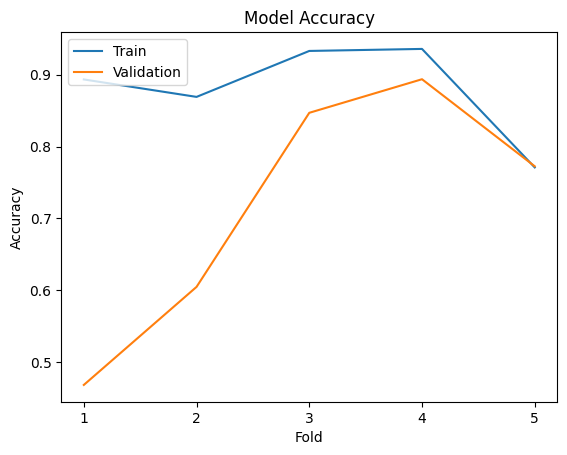

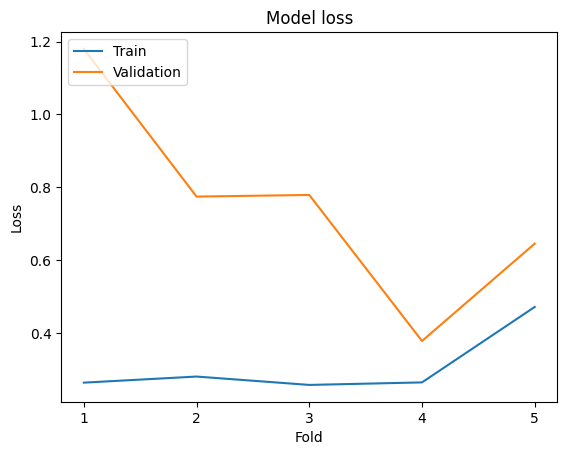

In [40]:
plt.plot([1, 2, 3, 4, 5], train_accuracy)
plt.plot([1, 2, 3, 4, 5], val_accuracy)
plt.xticks((1, 2, 3, 4, 5))
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Fold')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot([1, 2, 3, 4, 5], train_loss)
plt.plot([1, 2, 3, 4, 5], val_loss)
plt.xticks((1, 2, 3, 4, 5))
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Fold')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# End of file. Thank You!